In [1]:
!pip install -q transformers
!pip install -q kaggle

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 61 kB 486 kB/s 
     |████████████████████████████████| 3.3 MB 48.1 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 


In [2]:
!nvidia-smi 

Sun Dec 19 06:25:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import gc
import multiprocessing
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch
from torch.cuda.amp import autocast
from torch import nn
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
from transformers import AutoModel, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

# Training

In [ ]:
# preparing a toy dataset
os.environ['KAGGLE_USERNAME'] = "XXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXX"

!kaggle datasets download -d sajjadayobi360/flickrfa
!unzip flickrfa.zip

In [5]:
df = pd.read_csv('/content/dataset.csv')
df.image = df.image.apply(lambda x: '/content/images/'+os.path.basename(x))
df.dropna().to_csv('dataset.csv', index=False)

## Config: hyperparams
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/config.py

In [6]:
DATA_FILE = 'dataset.csv'
TEST_SIZE = 0.05
TEXT_MODEL = 'm3hrdadfi/roberta-zwnj-wnli-mean-tokens'
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
BATCH_SIZE = 32
IMAGE_SIZE = 224
MAX_LEN = 80
MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073])
STD = torch.tensor([0.26862954, 0.26130258, 0.27577711])

if __name__ == '__main__':
    from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor
    vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)
    tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
    args = TrainingArguments(
        "clip-fa",
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=100,
        logging_steps=10,
        learning_rate=3e-5,
        weight_decay=0.003,
        warmup_steps=100,
        fp16=False,
        prediction_loss_only=True,
        gradient_accumulation_steps=1,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=1,
        report_to='none'
    )

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/309 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/663 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/855k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Utils: some helper functions
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/utils.py

In [7]:
def clear_gpu():
    torch.clear_autocast_cache()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    gc.collect()


def optimal_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value


def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)


def clip_wraper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }
    DUMMY_CONFIG = CLIPConfig(text_config_dict=config,
                              vision_config_dict=config)
    clip = CLIPModel(config=DUMMY_CONFIG)
    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()
    return clip

## DataModule: datasets and dataloaders
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/data.py

torch.Size([32, 80])
torch.Size([32, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  مردی سیاه پوش در گوشه خیابان نزدیک چراغ گذرگاه ایستاده است.


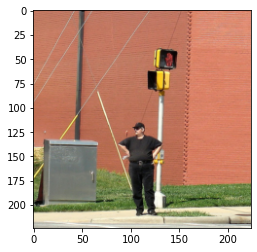

In [8]:
class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=MAX_LEN, truncation=True)

        if mode == 'train':
            self.augment = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)


if __name__ == '__main__':
    df = pd.read_csv(DATA_FILE)
    train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
    train_ds = CLIPDataset(image_paths=train_df.image.tolist(),
                           text=train_df.caption.tolist(), mode='train')
    test_ds = CLIPDataset(image_paths=test_df.image.tolist(),
                          text=test_df.caption.tolist(), mode='test')

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          collate_fn=default_data_collator)
    for item in train_dl:
        print(item['input_ids'].shape)
        print(item['pixel_values'].shape)
        break

    show_data(item)

## Model: define vision and text encoder
https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/model.py

In [9]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

clip = clip_wraper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder


if __name__ == '__main__':
    out = clip(input_ids=item['input_ids'],
               attention_mask=item['attention_mask'],
               pixel_values=item['pixel_values'],
               return_loss=True)

    print('text and image embeddings: ',
          out.text_embeds.shape, out.image_embeds.shape)
    print('loss: ', out.loss)
    del out, item

Downloading:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

You are using a model of type clip to instantiate a model of type clip_vision_model. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.2.layer_norm2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.9.mlp.fc2.bias', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.9.self_attn.v_proj.weight', 'text_model.encoder.layers.6.layer_norm2.bias', 'text_model.encoder.layers.4.mlp.fc1.weight', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.out_proj.weight', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.9.self_attn.v_proj.bias', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.10.layer_norm1.weight', 'text_model.encoder.laye

Downloading:   0%|          | 0.00/451M [00:00<?, ?B/s]

text and image embeddings:  torch.Size([32, 768]) torch.Size([32, 768])
loss:  tensor(3.5117, grad_fn=<DivBackward0>)


## Trainer: train using huggingface trainer
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/train.py

In [10]:
class CLIPTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs, return_loss=True)
        return outputs["loss"]

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            if self.use_amp:
                with autocast():
                    loss = self.compute_loss(model, inputs)
            else:
                loss = self.compute_loss(model, inputs)
        return (loss, None, None)


if __name__ == '__main__':
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    clear_gpu()
    args.dataloader_num_workers = optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds)

    trainer.train()

    # save pretrained models
    # clip.text_model.save_pretrained('clip-fa-text')
    # tokenizer.save_pretrained('clip-fa-text')
    # clip.vision_model.save_pretrained('clip-fa-vision')
    # vision_preprocessor.save_pretrained('clip-fa-vision')

***** Running training *****
  Num examples = 30762
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 962


Step,Training Loss,Validation Loss
100,2.256000,2.241064
200,1.787700,1.804439
300,1.662900,1.571994
400,1.384800,1.410259
500,1.275100,1.251577
600,1.157900,1.157334
700,1.047500,1.067008
800,1.062700,1.007318
900,0.984300,0.956795


***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
Saving model checkpoint to clip-fa/checkpoint-500
Configuration saved in clip-fa/checkpoint-500/config.json
Model weights saved in clip-fa/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




# Demo

## Utils: demo utils
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/utils.py

In [11]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

## CLIPDemo
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/main.py

In [43]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = 32, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = 'موز'):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=10):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = 'برف', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [44]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)
search.compute_image_embeddings(test_df.image.to_list())
search.compute_text_embeddings(['سگ', 'گربه', 'آدم', 'ماشین', 'درخت'])

computing text embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


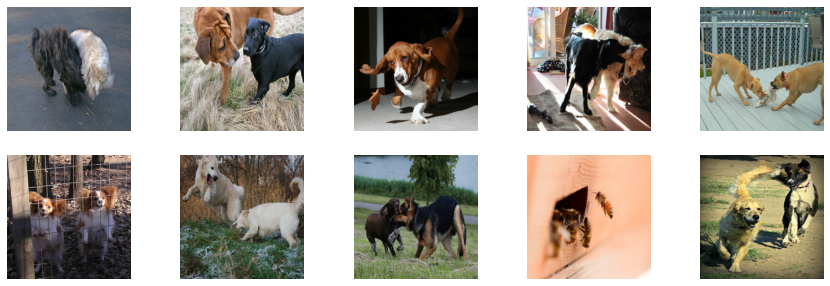

In [45]:
search.image_search('دو سگ')

label: درخت | 0.258
label: آدم | 0.207
label: ماشین | 0.2
label: گربه | 0.171
label: سگ | 0.164


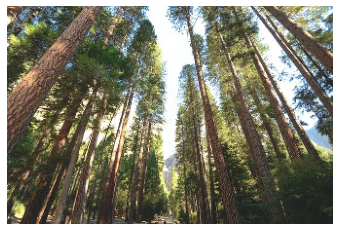

In [46]:
search.zero_shot('/content/images/000018288.jpg')